In [22]:
import numpy as np 
import pandas as pd
import re

from matplotlib import pyplot as plt
from matplotlib import style
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
 
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score, classification_report, plot_confusion_matrix, auc
from sklearn.metrics import mean_squared_error, confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from xgboost.sklearn import XGBClassifier


def accuracy(y, y_hat):
    y_y_hat = list(zip(y, y_hat))
    tp = sum([1 for i in y_y_hat if i[0] == 1 and i[1] == 1])
    tn = sum([1 for i in y_y_hat if i[0] == 0 and i[1] == 0])
    return (tp + tn) / float(len(y_y_hat))

def f1(y, y_hat):
    precision_score = precision(y, y_hat)
    recall_score = recall(y, y_hat)
    numerator = precision_score * recall_score
    denominator = precision_score + recall_score
    return 2 * (numerator / denominator)

def precision(y, y_hat):
    y_y_hat = list(zip(y, y_hat))
    tp = sum([1 for i in y_y_hat if i[0] == 1 and i[1] == 1])
    fp = sum([1 for i in y_y_hat if i[0] == 0 and i[1] == 1])
    return tp / float(tp + fp)

def recall(y, y_hat):
    # Your code here
    y_y_hat = list(zip(y, y_hat))
    tp = sum([1 for i in y_y_hat if i[0] == 1 and i[1] == 1])
    fn = sum([1 for i in y_y_hat if i[0] == 1 and i[1] == 0])
    return tp / float(tp + fn)

def get_metrics(y_tr, y_val, y_pred_tr, y_pred_val, model):
    print('Training Accuracy: ', accuracy(y_tr, y_pred_tr))
    print('Validation Accuracy: ', accuracy(y_val, y_pred_val))
    print('Training F1 Score: ', f1(y_tr, y_pred_tr))
    print('Validation F1 Score: ', f1(y_val, y_pred_val))
    print('Training AUC Score: {}'.format(roc_auc_score(y_tr, model.predict_proba(X_tr)[:,1])))
    print('Validation AUC Score: {}'.format(roc_auc_score(y_val, model.predict_proba(X_val)[:,1])))
    print('Training Recall Score: ', recall(y_tr, y_pred_tr))
    print('Validation Recall Score: ', recall(y_val, y_pred_val))
    print('Training Precision Score: ', precision(y_tr, y_pred_tr))
    print('Validation Precision Score: ', precision(y_val, y_pred_val))
    print('')
    print("Training Classification Report: ")
    print(classification_report(y_tr, y_pred_tr))
    print("")
    print("Validation Classification Report: ")
    print(classification_report(y_val, y_pred_val))
    
    cnf = confusion_matrix(y_val, y_pred_val)
    group_names = ['TN','FP','FN','TP']
    group_counts = ['{0:0.0f}'.format(value) for value in cnf.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cnf.flatten()/np.sum(cnf)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cnf, annot=labels, fmt='', cmap='Blues', annot_kws={'size':16})

In [4]:
tr = pd.read_csv("/Volumes/My Passport for Mac/Dropbox/Data Science/Flatiron/iPython Notebooks/course-materials/DS-Projects/Taiwan-CC-Default-Prediction/data/tr.csv")
val = pd.read_csv("/Volumes/My Passport for Mac/Dropbox/Data Science/Flatiron/iPython Notebooks/course-materials/DS-Projects/Taiwan-CC-Default-Prediction/data/val.csv")

In [5]:
tr.head()

,limit,gender,education,marriage,age,stat1,stat2,stat3,stat4,stat5,...,bill4,bill5,bill6,paid1,paid2,paid3,paid4,paid5,paid6,default
0,1786.639510,2,2,1,44,0,0,0,0,0,...,798.985189,845.402083,979.828840,107.770095,178.771149,107.198371,107.198371,178.663951,33.017098,0
1,5717.246431,2,3,1,46,0,0,0,0,0,...,147.469225,142.752497,30.087009,83.721927,173.518429,35.732790,142.752497,30.087009,940.236908,0
2,3573.279019,2,2,1,47,0,0,0,0,0,...,224.044595,-14.150185,-14.150185,238.194779,0.000000,224.044595,0.000000,0.000000,0.000000,1
3,6074.574333,2,2,1,29,0,0,0,0,0,...,2283.432492,1554.555037,1572.064105,79.862786,89.081846,92.369263,60.138286,67.928034,75.431920,0
4,5359.918529,2,1,2,33,0,0,0,0,0,...,1195.583427,993.371567,80.791839,965.035465,1168.998231,1196.155152,993.657430,80.791839,6055.457290,0


In [6]:
val.head()

,limit,gender,education,marriage,age,stat1,stat2,stat3,stat4,stat5,...,bill4,bill5,bill6,paid1,paid2,paid3,paid4,paid5,paid6,default
0,1071.983706,1,2,2,25,0,0,0,0,0,...,449.518501,490.110950,529.845813,53.599185,71.465580,53.599185,53.599185,53.599185,71.465580,0
1,5359.918529,2,1,2,26,0,0,0,0,0,...,3629.772561,2777.902843,2760.858302,160.297297,151.328366,112.951350,94.584696,95.370817,95.370817,0
2,2501.295314,2,3,1,32,0,0,0,0,0,...,2492.469314,2505.261653,2508.870665,86.866413,111.200443,107.198371,87.116542,89.331975,91.261546,0
3,4645.262725,1,3,2,49,0,0,0,0,0,...,603.812689,401.493631,248.128495,57.529792,64.604885,250.629790,0.964785,250.522592,157.510139,0
4,1786.639510,2,2,2,36,0,0,0,0,0,...,699.433635,725.196977,694.609709,71.465580,53.599185,35.732790,64.319022,0.000000,35.732790,1


In [7]:
X_train = tr.drop(["default"], axis=1)
y_tr = tr["default"]
X_validate = val.drop(["default"], axis=1)
y_val = val["default"]

In [8]:
scaler = StandardScaler()
scaler.fit(X_train)
X_tr = scaler.transform(X_train)
X_val = scaler.transform(X_validate)

Training Accuracy:  0.8207142857142857
Validation Accuracy:  0.8166666666666667
Training F1 Score:  0.4605244304341596
Validation F1 Score:  0.43705220061412486
Training AUC Score: 0.7616524339038844
Validation AUC Score: 0.7610603521496723
Training Recall Score:  0.34514604810996563
Validation Recall Score:  0.32520944402132523
Training Precision Score:  0.6917778734395179
Validation Precision Score:  0.6661466458658346

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.96      0.89     16344
           1       0.69      0.35      0.46      4656

    accuracy                           0.82     21000
   macro avg       0.76      0.65      0.68     21000
weighted avg       0.80      0.82      0.80     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.95      0.89      4687
           1       0.67      0.33      0.44      1313

    accuracy  

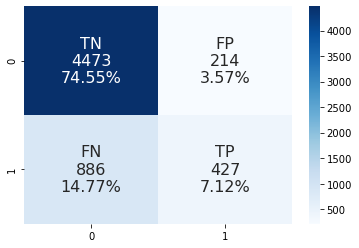

In [15]:
logreg = LogisticRegression(solver="liblinear", random_state=42).fit(X_tr, y_tr)
y_pred_log_tr = logreg.predict(X_tr)
y_pred_log_val = logreg.predict(X_val)
get_metrics(y_tr, y_val, y_pred_log_tr, y_pred_log_val, logreg)

Training Accuracy:  0.9994761904761905
Validation Accuracy:  0.8165
Training F1 Score:  0.9988188553634704
Validation F1 Score:  0.4626647144948756
Training AUC Score: 0.9999939814184046
Validation AUC Score: 0.7588364439503148
Training Recall Score:  0.998926116838488
Validation Recall Score:  0.361005331302361
Training Precision Score:  0.9987116169207645
Validation Precision Score:  0.6440217391304348

Training Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16344
           1       1.00      1.00      1.00      4656

    accuracy                           1.00     21000
   macro avg       1.00      1.00      1.00     21000
weighted avg       1.00      1.00      1.00     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      4687
           1       0.64      0.36      0.46      1313

    accuracy                   

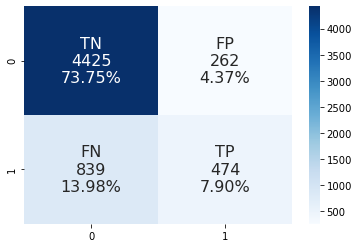

In [16]:
rfc = RandomForestClassifier().fit(X_tr, y_tr)
y_pred_rfc_tr = rfc.predict(X_tr)
y_pred_rfc_val = rfc.predict(X_val)
get_metrics(y_tr, y_val, y_pred_rfc_tr, y_pred_rfc_val, rfc)

Training Accuracy:  0.8666666666666667
Validation Accuracy:  0.78
Training F1 Score:  0.6588693957115009
Validation F1 Score:  0.43444730077120824
Training AUC Score: 0.917179901869261
Validation AUC Score: 0.6820246761837891
Training Recall Score:  0.5807560137457045
Validation Recall Score:  0.38613861386138615
Training Precision Score:  0.7612612612612613
Validation Precision Score:  0.49657198824681686

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.89      0.95      0.92     16344
           1       0.76      0.58      0.66      4656

    accuracy                           0.87     21000
   macro avg       0.82      0.76      0.79     21000
weighted avg       0.86      0.87      0.86     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      4687
           1       0.50      0.39      0.43      1313

    accuracy                 

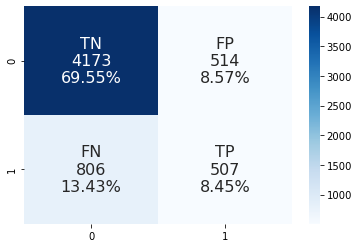

In [17]:
knn = KNeighborsClassifier(n_neighbors = 3).fit(X_tr, y_tr)
y_pred_knn_tr = knn.predict(X_tr)
y_pred_knn_val = knn.predict(X_val)
get_metrics(y_tr, y_val, y_pred_knn_tr, y_pred_knn_val, knn)

Training Accuracy:  0.7697619047619048
Validation Accuracy:  0.7658333333333334
Training F1 Score:  0.5205751115518097
Validation F1 Score:  0.5102823283373998
Training AUC Score: 0.748729803322215
Validation AUC Score: 0.7460293098946039
Training Recall Score:  0.5637886597938144
Validation Recall Score:  0.5575019040365575
Training Precision Score:  0.48351445938478543
Validation Precision Score:  0.4704370179948586

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.87      0.83      0.85     16344
           1       0.48      0.56      0.52      4656

    accuracy                           0.77     21000
   macro avg       0.68      0.70      0.68     21000
weighted avg       0.78      0.77      0.78     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0       0.87      0.82      0.85      4687
           1       0.47      0.56      0.51      1313

    accuracy     

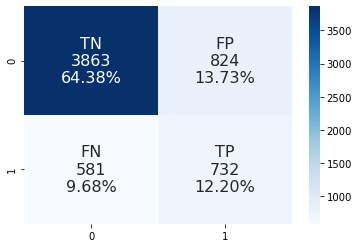

In [18]:
gnb = GaussianNB().fit(X_tr, y_tr)
y_pred_gnb_tr = gnb.predict(X_tr)
y_pred_gnb_val = gnb.predict(X_val)
get_metrics(y_tr, y_val, y_pred_gnb_tr, y_pred_gnb_val, gnb)

Training Accuracy:  0.9994761904761905
Validation Accuracy:  0.7238333333333333
Training F1 Score:  0.9988173314697344
Validation F1 Score:  0.38194703468854907
Training AUC Score: 0.9999991983985211
Validation AUC Score: 0.6042794552058643
Training Recall Score:  0.9976374570446735
Validation Recall Score:  0.38994668697638996
Training Precision Score:  1.0
Validation Precision Score:  0.3742690058479532

Training Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16344
           1       1.00      1.00      1.00      4656

    accuracy                           1.00     21000
   macro avg       1.00      1.00      1.00     21000
weighted avg       1.00      1.00      1.00     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.82      0.82      4687
           1       0.37      0.39      0.38      1313

    accuracy                  

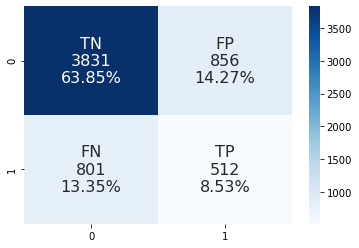

In [19]:
dtc = DecisionTreeClassifier().fit(X_tr, y_tr)
y_pred_dtc_tr = dtc.predict(X_tr)
y_pred_dtc_val = dtc.predict(X_val)
get_metrics(y_tr, y_val, y_pred_dtc_tr, y_pred_dtc_val, dtc)

Training Accuracy:  0.8186666666666667
Validation Accuracy:  0.8165
Training F1 Score:  0.44311202105878916
Validation F1 Score:  0.423861852433281
Training AUC Score: 0.7872104851996508
Validation AUC Score: 0.7775286637327632
Training Recall Score:  0.32538659793814434
Validation Recall Score:  0.30845392231530844
Training Precision Score:  0.6943171402383135
Validation Precision Score:  0.677257525083612

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.96      0.89     16344
           1       0.69      0.33      0.44      4656

    accuracy                           0.82     21000
   macro avg       0.76      0.64      0.67     21000
weighted avg       0.80      0.82      0.79     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      4687
           1       0.68      0.31      0.42      1313

    accuracy                

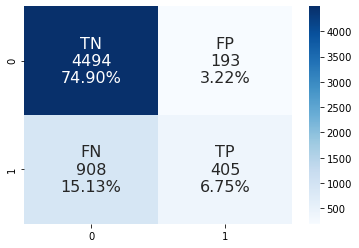

In [20]:
abc = AdaBoostClassifier().fit(X_tr, y_tr)
y_pred_abc_tr = abc.predict(X_tr)
y_pred_abc_val = abc.predict(X_val)
get_metrics(y_tr, y_val, y_pred_abc_tr, y_pred_abc_val, abc)

Training Accuracy:  0.8186666666666667
Validation Accuracy:  0.8165
Training F1 Score:  0.44311202105878916
Validation F1 Score:  0.423861852433281
Training AUC Score: 0.7601368683275218
Validation AUC Score: 0.7573192270237183
Training Recall Score:  0.32538659793814434
Validation Recall Score:  0.30845392231530844
Training Precision Score:  0.6943171402383135
Validation Precision Score:  0.677257525083612

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.96      0.89     16344
           1       0.69      0.33      0.44      4656

    accuracy                           0.82     21000
   macro avg       0.76      0.64      0.67     21000
weighted avg       0.80      0.82      0.79     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      4687
           1       0.68      0.31      0.42      1313

    accuracy                

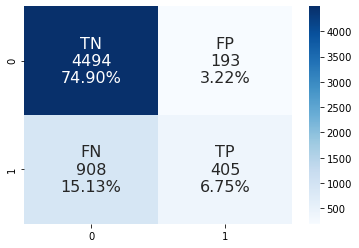

In [21]:
lda = LinearDiscriminantAnalysis().fit(X_tr, y_tr)
y_pred_lda_tr = abc.predict(X_tr)
y_pred_lda_val = abc.predict(X_val)
get_metrics(y_tr, y_val, y_pred_lda_tr, y_pred_lda_val, lda)